Code adapted from:
Juho Laitala, Mingzhe Jiang, Elise Syrjälä, Emad Kasaeyan Naeini, Antti
Airola, Amir M. Rahmani, Nikil D. Dutt, and Pasi Liljeberg. 2020. Robust
ECG R-peak Detection Using LSTM. In The 35th ACM/SIGAPP Symposium
on Applied Computing (SAC ’20), March 30-April 3, 2020, Brno, Czech Republic
ACM, New York, NY, USA, Article 4, 8 pages. https://doi.org/10.1145/3341105.
3373945

In [33]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Importing needed libraries
from matplotlib import pyplot as plt
from ecg2rr import data
import wfdb
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.signal import resample_poly


# Now you can import
from ecg2rr import data
import tensorflow
from tensorflow.keras import layers, models, Input
import numpy as np

In [34]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [35]:
# # path = 'saved_data/math_functions_single.nc'
import xarray as xr

path = '/nsls2/users/shasko/Repos/ecg2rr/ecg2rr/ds_combined_500_patterns_NaCl.nc'
ds = xr.open_dataset(path, engine="netcdf4")
gaussians = ds["Intensities"]
binary = ds["binary_arr"]
x = ds["tth"].values


In [36]:
# path = '/nsls2/users/shasko/Repos/ecg2rr/ecg2rr/math_functions_smalldataset.nc'
# ds = xr.open_dataset(path, engine="netcdf4")

# gaussians = ds["Gaussians"].values
# binary = ds["BinaryArr"].values
# print(type(binary))


# # for j in range(binary.shape[0]):
# #     idx = np.where(binary[j] == 1)[0][0] # because there's only 1 "1" we can use [0][0]
# #     binary[j][idx - 2] = 1
# #     binary[j][idx - 1] = 1
# #     binary[j][idx + 1] = 1
# #     binary[j][idx + 2] = 1

# x = ds["x"].values

In [37]:
ds

<xarray.Dataset> Size: 96MB
Dimensions:         (pattern: 500, tth: 11763, variation: 500, peak: 64,
                     hkl_index: 3)
Coordinates:
  * pattern         (pattern) int64 4kB 0 1 2 3 4 5 ... 494 495 496 497 498 499
  * tth             (tth) float64 94kB 0.0 0.0008502 0.0017 ... 9.998 9.999 10.0
  * variation       (variation) int64 4kB 0 1 2 3 4 5 ... 495 496 497 498 499
  * peak            (peak) int64 512B 0 1 2 3 4 5 6 7 ... 57 58 59 60 61 62 63
  * hkl_index       (hkl_index) <U1 12B 'h' 'k' 'l'
Data variables:
    Intensities     (pattern, tth) float64 47MB ...
    hkl             (variation, peak, hkl_index) float64 768kB ...
    2theta_calc     (variation, peak) float64 256kB ...
    2theta_nearest  (variation, peak) float64 256kB ...
    intensity       (variation, peak) float64 256kB ...
    binary_arr      (pattern, tth) int64 47MB ...
Attributes:
    CIF:        cif_files/NaCl_cubic.cif
    tth_range:  [ 0 10]

In [38]:
import sklearn
from sklearn.model_selection import train_test_split

train_gaussians, test_gaussians, train_binary, test_binary = train_test_split(gaussians, binary, test_size=0.2, shuffle=False)

In [39]:
gauss_signals_train = [signal for signal in train_gaussians]
gauss_signals_test = [signal for signal in test_gaussians]

binary_labels_train = [label for label in train_binary]
binary_labels_test = [label for label in test_binary]

In [40]:
# import sklearn
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# gauss_signals_train_sc = scaler.fit_transform(gauss_signals_train)
# gauss_signals_test_sc = scaler.transform(gauss_signals_test)

In [41]:
import wfdb
from wfdb.processing import (
    resample_singlechan,
    find_local_peaks,
    correct_peaks,
    normalize_bound
)

In [42]:
def data_generator(signals, labels, win_size, batch_size):
   
    while True:
        X, y = [], []

        while len(X) < batch_size:
            i = np.random.randint(0, len(signals))
            sig = signals[i]
            lbl = labels[i]

            if len(sig) <= win_size + 4:
                continue  # skip short signals

            start = np.random.randint(2, len(sig) - win_size - 2)
            end = start + win_size

            data_win = sig[start:end]
            label_win = lbl[start:end]

            # Pad 1s ±2 samples around every 1 in label_win
            padded_label = label_win.copy()
            ones = np.where(label_win == 1)[0]
            for p in ones:
                for offset in [-2, -1, 1, 2]:
                    if 0 <= p + offset < win_size:
                        padded_label[p + offset] = 1

            # Normalize signal window to (0, 1)
            # data_win = normalize_bound(data_win, lb=0, ub=1)

            # Normalized locally
            data_win = (data_win - np.min(data_win))/(np.max(data_win) - np.min(data_win))

            # Normalized globally
            # low = np.min(signals)
            # high = np.max(signals)
            # data_win = (data_win - low)/(high - low)

            X.append(data_win)
            y.append(padded_label)

        X = np.array(X).reshape(batch_size, win_size, 1)
        y = np.array(y).reshape(batch_size, win_size, 1).astype(int)

        yield X, y

In [43]:
gen = data_generator(gauss_signals_train, binary_labels_train, win_size=11753, batch_size=64)
X_batch, y_batch = next(gen)

In [44]:
n = next(gen)

<class 'tuple'>
2
(64, 11753, 1)
(64, 11753, 1)


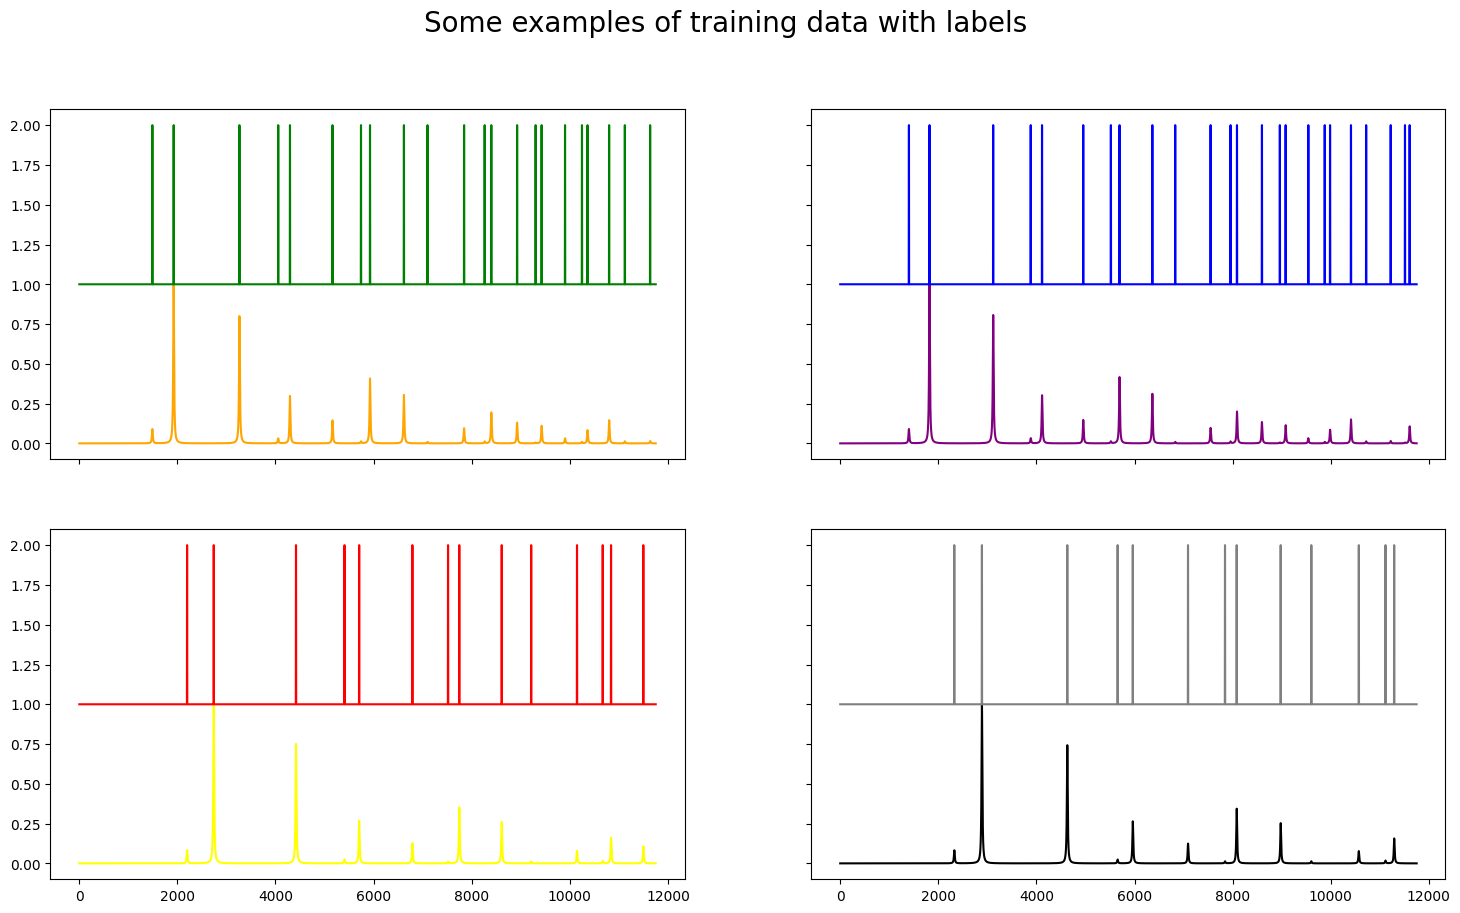

In [45]:

print(type(n))         # likely a tuple
print(len(n))          # 2: probably (inputs, labels)
print(n[0].shape)      # input batch shape
print(n[1].shape)      # label batch shape

# Plot 4 training examples with labels
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10), fig.set_figwidth(18)
fig.suptitle('Some examples of training data with labels', size=20)

# first index refers to whether it's an input or label, so noisy signal is input and peaks are labels
axs[0, 0].plot(n[0][0], color='orange')
axs[0, 0].plot(n[1][0]+1, color='green')

axs[0, 1].plot(n[0][1], color='purple')
axs[0, 1].plot(n[1][1]+1, color='blue')

axs[1, 0].plot(n[0][2], color='yellow')
axs[1, 0].plot(n[1][2]+1, color='red')

axs[1, 1].plot(n[0][3], color='black')
axs[1, 1].plot(n[1][3]+1, color='grey')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [46]:
n_batch, n_timesteps, n_input_dim = 64, 11753, 1

model = models.Sequential()
model.add(Input(shape=(n_timesteps, n_input_dim)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [47]:
training_gen = data_generator(gauss_signals_train, binary_labels_train, win_size=n_timesteps, batch_size=n_batch)

In [48]:
model.fit(training_gen,
          steps_per_epoch=40,
          epochs=8)

Epoch 1/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 834s 21s/step - acc: 0.8912 - loss: 0.4501
Epoch 2/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 773s 19s/step - acc: 0.9901 - loss: 0.0566
Epoch 3/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 783s 20s/step - acc: 0.9901 - loss: 0.0554
Epoch 4/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 752s 19s/step - acc: 0.9901 - loss: 0.0552
Epoch 5/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 783s 20s/step - acc: 0.9902 - loss: 0.0539
Epoch 6/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 737s 18s/step - acc: 0.9901 - loss: 0.0506
Epoch 7/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 736s 18s/step - acc: 0.9900 - loss: 0.0446
Epoch 8/8
40/40 ━━━━━━━━━━━━━━━━━━━━ 731s 18s/step - acc: 0.9902 - loss: 0.0446


In [49]:
testing_gen = data_generator(gauss_signals_test, binary_labels_test, win_size=n_timesteps, batch_size=n_batch)

In [50]:
gauss_test, label_test = next(testing_gen)

In [51]:
label_test.shape

(64, 11753, 1)

In [52]:
binary_pred = model.predict(gauss_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


In [53]:
binary_pred.shape

(64, 11753, 1)

In [54]:
np.where(binary_pred[5] > 1e-2)[0]
#binary_pred[5]
binary_pred[5][750:760]

array([[0.00403538],
       [0.00405554],
       [0.00407678],
       [0.00409903],
       [0.00412216],
       [0.00414603],
       [0.00417048],
       [0.00419532],
       [0.00422029],
       [0.00424512]], dtype=float32)

In [55]:
plt.close('all')

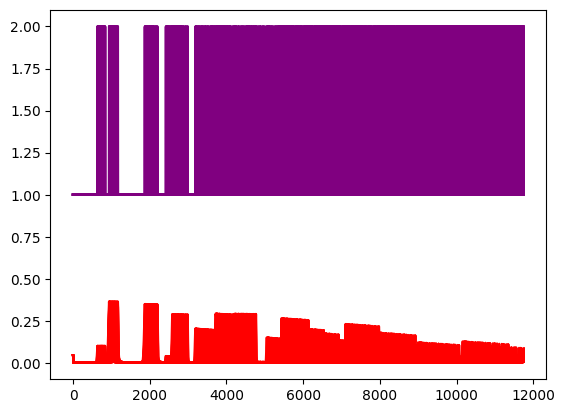

In [56]:
plt.figure()
for j in range(64):
    plt.plot(binary_pred[j], color='red')
    plt.plot(label_test[j] + 1, color='purple')
plt.show()

In [57]:
binary_pred.shape

(64, 11753, 1)

In [58]:
# evaluate accuracy
# use f1 score, set prob >= 60% as positive, else negative

binary_pred_adjusted = np.zeros_like(binary_pred)

for j in range(binary_pred.shape[0]):
    idx = np.where(binary_pred[j] >= 0.6)[0]
    binary_pred_adjusted[j][idx] = 1


In [60]:
plt.close('all')

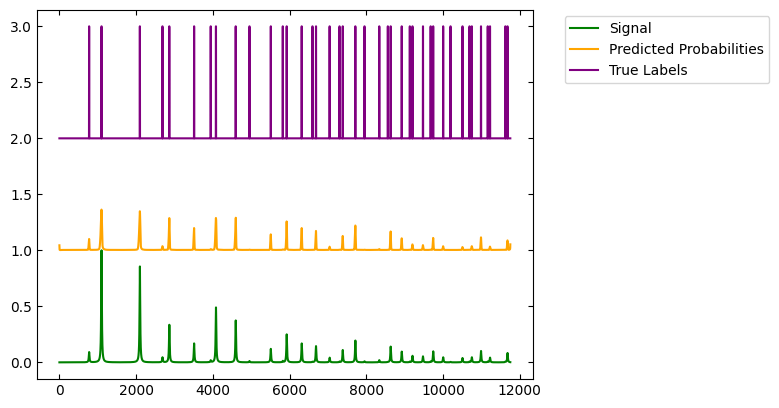

In [65]:
plt.figure()

for j in range(1):
    plt.plot(gauss_test[j], color='green', label='Signal')
    plt.plot(binary_pred[j] + 1, color='orange', label='Predicted Probabilities')
    plt.plot(label_test[j] + 2, color='purple', label='True Labels')

plt.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.savefig('test_RNN_NaCl_localscaling.png')
plt.show()